W0723 14:38:28.110530  7612 deprecation.py:323] From C:\Users\jeon\jhm\RaspberryPi\core\utils.py:122: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0723 14:38:28.126191  7612 deprecation_wrapper.py:119] From C:\Users\jeon\jhm\RaspberryPi\core\utils.py:123: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



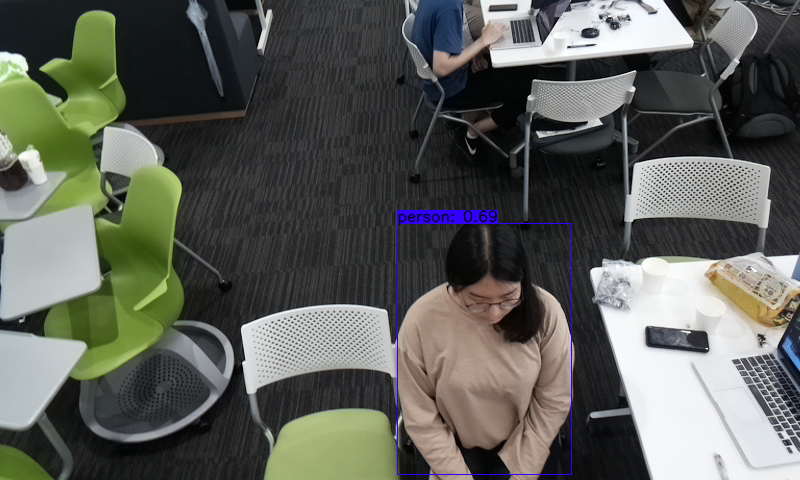

In [1]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from IPython.display import display

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
image_path      = "./docs/images/pic5.jpg"
num_classes     = 80
input_size      = 128
graph           = tf.Graph()

original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...]

return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)


with tf.Session(graph=graph) as sess:
    pred_sbbox, pred_mbbox, pred_lbbox = sess.run(
        [return_tensors[1], return_tensors[2], return_tensors[3]],
                feed_dict={ return_tensors[0]: image_data})

pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)

bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.5)
bboxes = utils.nms(bboxes, 0.4, method='nms')
image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)
# image.show()
display(image)

In [4]:
len(bboxes)

2

In [3]:
bboxes[0]

array([399.01287842, 219.5496521 , 574.82592773, 471.54928589,
         0.9978981 ,   0.        ])

In [4]:
bboxes[1]

array([402.72622681,  11.59717941, 526.85723877, 186.44424438,
         0.6120711 ,   0.        ])

In [71]:
# ai 서버, display 클라이언트
# server.py

import flask
from flask import request, make_response, jsonify
from PIL import Image
import time

import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from IPython.display import display

import requests

num_seats = input("좌석 수 :")
num_seats = int(num_seats)
global empty_num_seats
empty_num_seats = num_seats

app = flask.Flask(__name__)

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
image_path      = "./images/capture.jpg"
num_classes     = 80
input_size      = 128
graph           = tf.Graph()

# IP = "172.29.148.144"
# PORT = 8899


@app.route('/api/calculateEmptySeats', methods=['POST'])
def match():
    image = request.files['file']
    if image:
        image_path = 'images/test{}.jpg'.format(time.time())
        with open(image_path, 'wb') as fw:
            fw.write(image.read())
            
            start = time.time()
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            original_image_size = original_image.shape[:2]
            image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
            image_data = image_data[np.newaxis, ...]
            
            pred_sbbox, pred_mbbox, pred_lbbox = sess.run([return_tensors[1], return_tensors[2], return_tensors[3]],feed_dict={ return_tensors[0]: image_data})
            pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),np.reshape(pred_mbbox, (-1, 5 + num_classes)),np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)
            
            bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.5)
            bboxes = utils.nms(bboxes, 0.4, method='nms')
            image = utils.draw_bbox(original_image, bboxes)
            image = Image.fromarray(image)
            print("좌석 수: {}".format(num_seats))
            print("찾은 사람 수: {}".format(len(bboxes)))
            
#             requests.post(url="http://{}:{}/api/displayEmptySeats".format(IP,PORT), data={"num_empty_seats": num_seats})
            
            image.show()
            # display(image)
            end = time.time()
            print("{}seconds".format(end-start))
    else:
        print('Image empty!')
    return 'OK'

@app.route("/api/displayEmptySeats", methods=["POST"])
def display():
    global empty_num_seats
    
    if empty_num_seats < 9:
        empty_num_seats += 1
    else:
        empty_num_seats = 0
    return make_response(jsonify({"num_empty_seats": empty_num_seats}))

return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)
with tf.Session(graph=graph) as sess:
    app.run('0.0.0.0', port=5001, threaded=True)


좌석 수 :4
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
좌석 수: 4
찾은 사람 수: 0
26.054325819015503seconds
좌석 수: 4
찾은 사람 수: 0
3.676372766494751seconds
좌석 수: 4
찾은 사람 수: 0
4.048808574676514seconds
좌석 수: 4
찾은 사람 수: 0
3.532858371734619seconds
좌석 수: 4
찾은 사람 수: 0
3.5431642532348633seconds
좌석 수: 4
찾은 사람 수: 1
3.4822275638580322seconds
좌석 수: 4
찾은 사람 수: 3
4.008602142333984seconds
좌석 수: 4
찾은 사람 수: 3
3.3927299976348877seconds
좌석 수: 4
찾은 사람 수: 2
3.4873054027557373seconds
좌석 수: 4
찾은 사람 수: 2
3.751009941101074seconds
좌석 수: 4
찾은 사람 수: 2
4.2720537185668945seconds
좌석 수: 4
찾은 사람 수: 2
3.733417272567749seconds
좌석 수: 4
찾은 사람 수: 2
3.65000319480896seconds
좌석 수: 4
찾은 사람 수: 2
3.7615737915039062seconds
좌석 수: 4
찾은 사람 수: 0
3.840515375137329seconds
좌석 수: 4
찾은 사람 수: 1
3.498950719833374seconds


In [7]:
# # display 서버

# import flask
# from flask import request, make_response, jsonify
# import time

# app = flask.Flask(__name__)

# @app.route("/api/displayEmptySeats", methods=["POST"])
# def match():
#     num_empty_seats = int(request.values["num_empty_seats"])
#     print("빈 좌석 수: {}".format(num_empty_seats))
    
#     return make_response(jsonify({"num_empty_seats": 4}))

# app.run("0.0.0.0", port=8899, threaded=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [59]:
# 빈 좌석 수 요청
# response.py


import requests

IP = "172.29.148.137"
PORT = 5001

res = requests.post(url="http://{}:{}/api/displayEmptySeats".format(IP,PORT))
res = res.text
res = res.split(':')[1]
res = res.split('}')[0]
res = int(res)
print(res)

4


In [ ]:
# 카메라로 찍은 사진 server에 전달
# client.py

from picamera import PiCamera
import time
from PIL import Image
import socket
import base64
import requests
from io import BytesIO

IP = '172.29.148.137'
PORT = 5001
#IMAGE_SIZE = (1920, 1080)
#IMAGE_SIZE = (1366, 768)
#time.sleep(5)

#with PiCamera(resolution=IMAGE_SIZE) as camera:
with PiCamera() as camera:
        stream = BytesIO()
        for i in camera.capture_continuous(stream, format='jpeg', use_video_port = True):
                stream.truncate()
                stream.seek(0)
                barray = stream.read(stream.getbuffer().nbytes)
                requests.post('http://{}:{}/api/calculateEmptySeats'.format(IP, PORT), files={'file': barray})
                time.sleep(10)
                stream.seek(0)